# Case study 3: The Escherichia coli K-12 transcriptional motif

This is case study 3 in Figure 7 in this paper: *Eliater: an open source software for causal query estimation from observational measurements of biomolecular networks. The figure below shows the transcriptional regulatory network motif of E. coli from the EcoCyc database (Keseler et al., 2021). It comprises 44 nodes, of which 7 are latent and 45 are
observed, connected by a total of 147 directed edges.

![ecoli](../img/ecoli.png)

In [21]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import set_matplotlib_formats
from matplotlib.lines import Line2D

from eliater import version_df
from eliater.data import load_ecoli_obs
from eliater.discover_latent_nodes import find_nuisance_variables, remove_nuisance_variables
from eliater.examples import ecoli_transcription_example
from eliater.network_validation import print_graph_falsifications, add_ci_undirected_edges
from eliater.regression import estimate_query_by_linear_regression, fit_regression, summary_statistics
from y0.algorithm.identify import Identification, identify_outcomes
from y0.dsl import P, Variable

set_matplotlib_formats("svg")

version_df()

,key,value
0,eliater,0.0.3-dev-80ab64d2
1,y0,0.2.12-dev-80ab64d2
2,Run at,2024-05-02 19:52:50


In [22]:
treatment = Variable("fur")
outcome = Variable("dpiA")

In [23]:
graph = ecoli_transcription_example.graph

The observational data are 260 RNA-seq normalized expression profiles of E. coli K-12 MG1655 and BW25113 strains, spanning 154 distinct experimental conditions. These data were retrieved from the PRECISE database (Sastry et al., 2019).

In [24]:
data = load_ecoli_obs()
data.head()

,cra,aceE,phoB,cyoA,amtB,appY,citC,dpiB,dpiA,fur,...,mdh,fis,crp,rpoH,gadX,cspA,oxyR,soxS,dcuR,arcA
1,7.697991,10.651307,5.599989,11.254009,5.128441,5.919468,0.000000,4.323397,4.761679,9.737595,...,11.745289,8.936196,9.666416,8.725102,8.614542,7.743336,8.209081,6.230069,5.752131,9.547993
2,7.581105,10.761484,5.746619,11.431429,5.614179,5.628823,0.000000,4.706430,4.930888,9.784892,...,11.843169,8.601549,9.621358,8.769579,8.456629,7.474558,8.417561,6.104497,5.667736,9.560289
3,6.395808,12.109947,6.009650,9.937863,3.866721,5.789442,0.000000,4.776288,5.291245,9.381882,...,11.166194,7.013285,9.761605,9.649581,8.391347,3.629759,7.841489,8.009047,5.725878,10.737478
4,6.366865,11.992996,6.131477,9.838573,3.666917,5.496674,0.377771,4.659630,5.366084,9.468696,...,11.030617,7.078497,9.706964,9.746059,8.180204,4.538549,7.754378,8.172509,5.470773,10.788613
5,7.315204,10.569824,5.158324,11.272986,6.146377,5.275278,0.190837,4.332369,4.786446,9.779253,...,11.423517,9.878379,9.692445,8.226875,8.142990,7.147757,7.979421,6.161353,5.738662,9.470079


## Step 1: Verify correctness of the network structure

The total number of d-separations implied by this network is large. It takes several hours to find all of them and test them against data. On the other hand, High-dimensional conditional independence tests can be very unreliable. Hence, it is best to control number of variables to condition upon. Here we selected 3. However, the default in this function is 5. Even with max_given equal to 3, it takes around an hour to produce the results.

In [25]:
print_graph_falsifications(
    graph,
    data,
    max_given=3,
    method="pearson",
    verbose=True,
    significance_level=0.01,
    show_progress=True,
)

Checking d-separations:   0%|          | 0/946 [00:00<?, ?pair/s]

Checking conditionals:   0%|          | 0/498 [00:00<?, ?it/s]

Of the 498 d-separations implied by the network's structure, 201 (40.36%) rejected the null hypothesis at p<0.01.

Since this is more than 30%, Eliater considers this a major inconsistency and therefore suggests adding appropriate bidirected edges using the eliater.add_ci_undirected_edges() function.

Finished in 1168.38 seconds.


,left,right,given,stats,p,dof,p_adj,p_adj_significant
0,appA,appB,appY,0.899419,5.350841e-94,None,2.664719e-91,True
1,appA,phoB,appY,0.840764,3.572616e-70,None,1.775590e-67,True
2,appA,narL,appY,0.838726,1.583492e-69,None,7.854120e-67,True
3,appA,arcA,appY,0.833926,4.864309e-68,None,2.407833e-65,True
4,appA,rpoS,appY,0.832139,1.693584e-67,None,8.366305e-65,True
...,...,...,...,...,...,...,...,...
493,gutM,modE,,0.137754,2.693370e-02,None,1.000000e+00,False
494,cra,narL,phoB,0.031518,6.143216e-01,None,1.000000e+00,False
495,gutM,lrp,crp|hns,0.099114,1.122438e-01,None,1.000000e+00,False
496,citC,narP,,0.093459,1.343524e-01,None,1.000000e+00,False


In [26]:
graph = add_ci_undirected_edges(
    graph=graph,
    data=data,
    method="pearson",
    significance_level=0.01,
    max_conditions=3
)

## Step 2: Check query identifiability

In [27]:
identify_outcomes(graph=graph, treatments=treatment, outcomes=outcome)

Sum[arcA, crp, dcuR, fnr, ihfA, ihfB, modE, narL, rpoD, rpoS](P(dcuR | arcA, crp, fnr, fur, ihfA, ihfB, lrp, modE, narL, oxyR, rpoD, rpoS, soxS) * P(dpiA | arcA, crp, dcuR, fnr, fur, ihfA, ihfB, lrp, modE, narL, oxyR, rpoD, rpoS, soxS) * Sum[arcA, crp, dcuR, dpiA, fnr, fur, ihfA, ihfB, lrp, modE, narL, oxyR, rpoS, soxS](Sum[aceE, amtB, appA, appB, appY, aspC, btsR, cirA, citC, cra, cspA, cydD, cyoA, dpiB, exuT, fis, gadX, gutM, hcp, hns, hyaA, hyaB, hyaF, iscR, mdh, narP, phoB, rpoH, ydeO](P(aceE, amtB, appA, appB, appY, arcA, aspC, btsR, cirA, citC, cra, crp, cspA, cydD, cyoA, dcuR, dpiA, dpiB, exuT, fis, fnr, fur, gadX, gutM, hcp, hns, hyaA, hyaB, hyaF, ihfA, ihfB, iscR, lrp, mdh, modE, narL, narP, oxyR, phoB, rpoD, rpoH, rpoS, soxS, ydeO))) * Sum[lrp, oxyR, soxS](P(arcA | modE, rpoD) * P(crp | arcA, ihfA, lrp, modE, rpoD, rpoS, soxS) * P(fnr | arcA, crp, fur, ihfA, ihfB, lrp, modE, oxyR, rpoD, rpoS, soxS) * P(ihfA | arcA, lrp, modE, rpoD, rpoS) * P(ihfB | arcA, crp, ihfA, lrp, modE,

The query is identifiable. Hence, we can proceed to the next step.

## Step 3: Find nuisance variables and mark them as latent

This function finds the nuisance variables for the input graph.

In [28]:
nuisance_variables = find_nuisance_variables(graph, treatments=treatment, outcomes=outcome)
print(f"{len(nuisance_variables)} nuisance variables were found")
sorted(nuisance_variables)

21 nuisance variables were found


[aceE,
 amtB,
 appA,
 appB,
 appY,
 aspC,
 cirA,
 citC,
 cydD,
 cyoA,
 dpiB,
 exuT,
 gadX,
 gutM,
 hcp,
 hns,
 hyaA,
 hyaB,
 hyaF,
 mdh,
 ydeO]

## Step 4: Simplify the network

The following function find the nuisance variable (step 3), marks them as latent and then applies Evan's simplification rules to remove the nuisance variables.

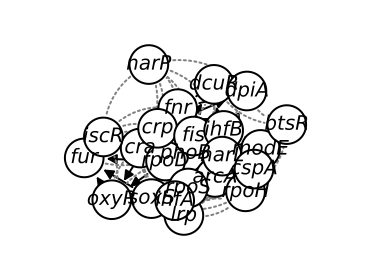

In [29]:
new_graph = remove_nuisance_variables(graph, treatments=treatment, outcomes=outcome)
new_graph.draw()

## Step 5: Estimate the query

In [30]:
fit_regression(new_graph, data, treatments=treatment, outcome=outcome)

RegressionResult(coefficients={crp: 0.3594042098545456, fur: 0.044351916282734175, oxyR: 0.0048560533728563655, rpoD: 0.16057485131792595, soxS: 0.04278193768977509}, intercept=-1.0375040603513126)

In [31]:
estimate_query_by_linear_regression(
    new_graph,
    data,
    treatments=treatment,
    outcome=outcome,
    interventions={treatment: 0},
    query_type="expected_value",
)

4.423519885608114

The estimated value for the query $\mathbb{E}[\text{dpiA} \mid \text{fur} = 0]$ is 4.07. This shows that perturbation of gene fur has an increasing effect on gene dpiA.

In [32]:
summary_statistics(
    new_graph,
    data,
    treatments=treatment,
    outcome=outcome,
    interventions={treatment: 0},
)

SummaryStatistics(size=258.0, mean=4.423519885608114, std=0.15220522779231585, min=4.099885544063996, first_quartile=4.335753777686982, second_quartile=4.417174129467719, third_quartile=4.50370821066422, max=4.950793944054751)

The summary statistics provides more details regarding the query in the form of $P(\text{dpiA} \mid \text{fur}=0)$. This result can be used to generate box plots that shows the estimated distribution of dpiA given a perturbation on fur.

## Evaluation criterion
The PRECISE database that the observational data was retrieved from included an interventional experiment with the value of fur set to zero, and three biological replicates. Hence, the ground truth for the query $\mathbb{E}[\text{dpiA} \mid \text{fur} = 0]$ was the mean expression of dpiA over the three replicates, resulted in 4.9.

The estimated value for the query (4.41) is close in sign and magnitude to the
value of 4.9 obtained from the experimental interventional data.

In [33]:
# TODO use variables from previous analysis for this, these are just magic constants
(4.07 - 4.9) / 4.9

-0.16938775510204082

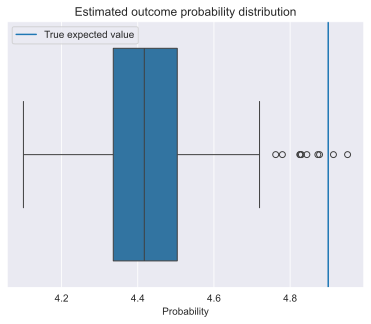

In [34]:
x = estimate_query_by_linear_regression(
    new_graph,
    data,
    treatments=treatment,
    outcome=outcome,
    interventions={treatment: 0},
    query_type="probability",
)
ax = sns.boxplot(x=x)
ax.axvline(x=4.9, label="True expected value")
ax.legend()
ax.set(xlabel="Probability", title="Estimated outcome probability distribution")
plt.show()

### Regression analysis of dpiA vs rpoS

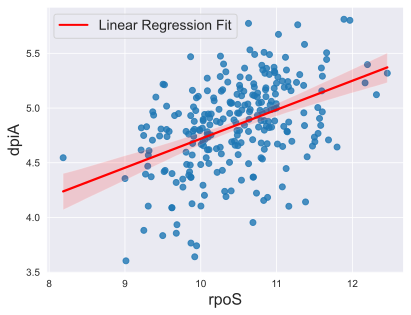

In [35]:
# Scatter plot with linear regression fit
sns.regplot(x="rpoS", y="dpiA", data=data, line_kws={"color": "red"})

plt.xlabel("rpoS", fontsize=16)
plt.ylabel("dpiA", fontsize=16)
custom_legend = [Line2D([0], [0], color="red", lw=2, label="Linear Regression Fit")]
plt.legend(handles=custom_legend, loc="upper left", fontsize=14)
plt.savefig("scatter_plot_with_regression.png", dpi=300, bbox_inches="tight")
plt.show()